### Regression: Find critical temperature of superconductors 

In [2]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import sys
sys.path.append("..")
from bpitnorm.modules.BatchPitNormalization import BatchPitNorm1d

device = "cuda" if torch.cuda.is_available() else "cpu"

# fetch dataset 
superconductivty_data = fetch_ucirepo(id=464) 
  
# data (as pandas dataframes) 
X_df = superconductivty_data.data.features 
y_df = superconductivty_data.data.targets

X = X_df.values
y = y_df.values

# data = data[~(np.isnan(data)).any(axis=1)]
# data = data[~(np.isinf(data)).any(axis=1)]
print("Number of features: ", X.shape[1])
print("Number of datapoints: ", X.shape[0])

def data_split(X, y, grid_search: bool=False):
  if grid_search:
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=0)
  else:
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2)
  y_train_raw = y_train_raw.reshape(-1, 1)
  y_test_raw = y_test_raw.reshape(-1, 1)

  scaler1 = StandardScaler()
  scaler_x = scaler1.fit(X_train_raw)
  X_train = scaler_x.transform(X_train_raw)
  X_test = scaler_x.transform(X_test_raw)

  scaler2 = StandardScaler()
  scaler_y = scaler2.fit(y_train_raw)
  y_train = scaler_y.transform(y_train_raw)
  y_test = scaler_y.transform(y_test_raw)

  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
  y_train = torch.tensor(y_train, dtype=torch.float32, device=device).reshape(-1, 1)
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device=device)
  y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device=device)
  return X_train, y_train, X_test, y_test, scaler_y  

Number of features:  81
Number of datapoints:  21263


In [3]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

def train_model(model, loops, grid_search: bool=False):
    model.to(device=device)
    r2score_lst = np.zeros(loops)
    meanAbsoluteError_lst = np.zeros(loops)
    torch.backends.cudnn.deterministic = True
    for i in range(loops):
        X_train, y_train, X_test, y_test, scaler_y = data_split(X, y, grid_search)
        loss_fn = nn.MSELoss().to(device=device)
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=100, shuffle=True)
        n_epochs = 30
        for epoch in range(n_epochs):
            model.train()
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.to(device=device)
                y_batch = y_batch.to(device=device)
                y_pred = model(x_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward(retain_graph=True)
                optimizer.step()
                optimizer.zero_grad()
        
        model.eval()
        y_test_inverse = scaler_y.inverse_transform(y_test.cpu())
        y_pred = model(X_test)
        y_pred = scaler_y.inverse_transform(y_pred.cpu().detach().numpy())
        r2score = r2_score(y_test_inverse, y_pred)
        r2score_lst[i] = r2score
        meanAbsoluteError = mean_absolute_error(y_test_inverse, y_pred)
        meanAbsoluteError_lst[i] = meanAbsoluteError
    return r2score_lst, meanAbsoluteError_lst

## Grid search

In [4]:
from itertools import product
import pandas as pd


param_grid = {
  'num_pit_samples': [1000, 500, 250, 150, 100, 50], # [50, 100, 150, 250, 500, 1000],
  'take_num_samples_when_full': [0, 1, 2, 3, 5, 10],
  'normal_backtransform': [True, False],
  'trainable_bandwidths': [True, False]
}

best_mae_4 = np.inf
best_params_4 = None
best_mae_5 = np.inf
best_params_5 = None
best_mae_6 = np.inf
best_params_6 = None

In [4]:
result = np.array(["mae", "r2", "num_pit_samples", "take_num_samples_when_full", "normal_backtransform", "trainable_bandwidths", "model_id"])
for params in product(*param_grid.values()):
  num_pit_samples, take_num_samples_when_full, normal_backtransform, trainable_bandwidths = params
 
  print(f"num_pit_samples={num_pit_samples}, take_num_samples_when_full={take_num_samples_when_full},"+
        f" normal_backtransform={normal_backtransform}, trainable_bandwidths={trainable_bandwidths}")

  model4 = nn.Sequential(
    nn.Linear(X.shape[1], 50),
    nn.ReLU(),
    nn.Linear(50, 80),
    BatchPitNorm1d(num_features=80, num_pit_samples=num_pit_samples, take_num_samples_when_full=take_num_samples_when_full,
                    normal_backtransform=normal_backtransform, trainable_bandwidths=trainable_bandwidths, bw_select = "RuleOfThumb", dev=device),
    nn.ReLU(),
    nn.Linear(80, 10),
    nn.ReLU(),
    nn.Linear(10, 1))
  model4.to(device=device)
  try:
    r2_4, mae_4 = train_model(model4, 1, True)
    if np.mean(mae_4) < np.mean(best_mae_4):
      best_mae_4 = mae_4
      best_r2_4 = r2_4
      best_params_4 = params

    values = np.array([np.mean(mae_4), np.mean(r2_4), num_pit_samples, take_num_samples_when_full, normal_backtransform, trainable_bandwidths, "model 4"])
    result = np.vstack((result, values))
  except Exception as e: 
    print(e)
    df = pd.DataFrame(result)
    df.to_csv("conductivivity4.csv", index=False)
    break

print(f"Model 4: Best params: {best_params_4} with MAE: {np.mean(best_mae_4)}, R2-score: {np.mean(best_r2_4)}")
df = pd.DataFrame(result)
df.to_csv("conductivivity4.csv", index=False)


num_pit_samples=1000, take_num_samples_when_full=0, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=1000, take_num_samples_when_full=0, normal_backtransform=True, trainable_bandwidths=False
num_pit_samples=1000, take_num_samples_when_full=0, normal_backtransform=False, trainable_bandwidths=True
num_pit_samples=1000, take_num_samples_when_full=0, normal_backtransform=False, trainable_bandwidths=False
num_pit_samples=1000, take_num_samples_when_full=1, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=1000, take_num_samples_when_full=1, normal_backtransform=True, trainable_bandwidths=False
num_pit_samples=1000, take_num_samples_when_full=1, normal_backtransform=False, trainable_bandwidths=True
num_pit_samples=1000, take_num_samples_when_full=1, normal_backtransform=False, trainable_bandwidths=False
num_pit_samples=1000, take_num_samples_when_full=2, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=1000, take_num_samples_when_ful

In [5]:
result = np.array(["mae", "r2", "num_pit_samples", "take_num_samples_when_full", "normal_backtransform", "trainable_bandwidths", "model_id"])
for params in product(*param_grid.values()):
  num_pit_samples, take_num_samples_when_full, normal_backtransform, trainable_bandwidths = params
 
  print(f"num_pit_samples={num_pit_samples}, take_num_samples_when_full={take_num_samples_when_full},"+
        f" normal_backtransform={normal_backtransform}, trainable_bandwidths={trainable_bandwidths}")

  model5 = nn.Sequential(
    nn.Linear(X.shape[1], 50),
    BatchPitNorm1d(num_features=50, num_pit_samples=num_pit_samples, take_num_samples_when_full=take_num_samples_when_full,
                    normal_backtransform=normal_backtransform, trainable_bandwidths=trainable_bandwidths, bw_select = "RuleOfThumb", dev=device),
    nn.ReLU(),
    nn.Linear(50, 80),
    nn.ReLU(),
    nn.BatchNorm1d(80),
    nn.Linear(80, 10),
    nn.ReLU(),
    nn.Linear(10, 1))
  model5.to(device=device)
  
  try:
    r2_5, mae_5 = train_model(model5, 1, True)
    if np.mean(mae_5) < np.mean(best_mae_5):
      best_mae_5 = mae_5
      best_r2_5 = r2_5
      best_params_5 = params
    values = np.array([np.mean(mae_5), np.mean(r2_5), num_pit_samples, take_num_samples_when_full, normal_backtransform, trainable_bandwidths, "model 5"])
    result = np.vstack((result, values))
  except Exception as e: 
    print(e)
    df = pd.DataFrame(result)
    df.to_csv("conductivivity5.csv", index=False)
    break
  
print(f"Model 5: Best params: {best_params_5} with MAE: {np.mean(best_mae_5)}, R2-score: {np.mean(best_r2_5)}")
df = pd.DataFrame(result)
df.to_csv("conductivivity5.csv", index=False)

num_pit_samples=1000, take_num_samples_when_full=0, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=1000, take_num_samples_when_full=0, normal_backtransform=True, trainable_bandwidths=False
num_pit_samples=1000, take_num_samples_when_full=0, normal_backtransform=False, trainable_bandwidths=True
num_pit_samples=1000, take_num_samples_when_full=0, normal_backtransform=False, trainable_bandwidths=False
num_pit_samples=1000, take_num_samples_when_full=1, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=1000, take_num_samples_when_full=1, normal_backtransform=True, trainable_bandwidths=False
num_pit_samples=1000, take_num_samples_when_full=1, normal_backtransform=False, trainable_bandwidths=True
num_pit_samples=1000, take_num_samples_when_full=1, normal_backtransform=False, trainable_bandwidths=False
num_pit_samples=1000, take_num_samples_when_full=2, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=1000, take_num_samples_when_ful

In [6]:
result = np.array(["mae", "r2", "num_pit_samples", "take_num_samples_when_full", "normal_backtransform", "trainable_bandwidths", "model_id"])
for params in product(*param_grid.values()):
  num_pit_samples, take_num_samples_when_full, normal_backtransform, trainable_bandwidths = params
 
  print(f"num_pit_samples={num_pit_samples}, take_num_samples_when_full={take_num_samples_when_full},"+
        f" normal_backtransform={normal_backtransform}, trainable_bandwidths={trainable_bandwidths}")

  model6 = nn.Sequential(
    nn.Linear(X.shape[1], 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 50),
    nn.Dropout(p=0.3),
    nn.ReLU(),
    nn.Linear(50, 10),
    BatchPitNorm1d(num_features=10, num_pit_samples=num_pit_samples, take_num_samples_when_full=take_num_samples_when_full,
                    normal_backtransform=normal_backtransform, trainable_bandwidths=trainable_bandwidths, bw_select = "RuleOfThumb", dev=device),
    nn.ReLU(),
    nn.Linear(10, 1))
  model6.to(device=device)

  mae_6, r2_6 = train_model(model6, 1, True)
  if np.mean(mae_6) < np.mean(best_mae_6):
    best_mae_6 = mae_6
    best_r2_6 = r2_6
    best_params_6 = params

  values = np.array([np.mean(mae_6), np.mean(r2_6), num_pit_samples, take_num_samples_when_full, normal_backtransform, trainable_bandwidths, "model 6"])
  result = np.vstack((result, values))
print(f"Model 6: Best params: {best_params_6} with MAE: {np.mean(best_mae_6)}, R2-score: {np.mean(best_r2_6)}")
df = pd.DataFrame(result)
df.to_csv("conductivivity6.csv", index=False)

num_pit_samples=1000, take_num_samples_when_full=0, normal_backtransform=True, trainable_bandwidths=True


num_pit_samples=1000, take_num_samples_when_full=0, normal_backtransform=True, trainable_bandwidths=False
num_pit_samples=1000, take_num_samples_when_full=0, normal_backtransform=False, trainable_bandwidths=True
num_pit_samples=1000, take_num_samples_when_full=0, normal_backtransform=False, trainable_bandwidths=False
num_pit_samples=1000, take_num_samples_when_full=1, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=1000, take_num_samples_when_full=1, normal_backtransform=True, trainable_bandwidths=False
num_pit_samples=1000, take_num_samples_when_full=1, normal_backtransform=False, trainable_bandwidths=True
num_pit_samples=1000, take_num_samples_when_full=1, normal_backtransform=False, trainable_bandwidths=False
num_pit_samples=1000, take_num_samples_when_full=2, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=1000, take_num_samples_when_full=2, normal_backtransform=True, trainable_bandwidths=False
num_pit_samples=1000, take_num_samples_when_fu

## Comparison  (hyperparameters from grid search)

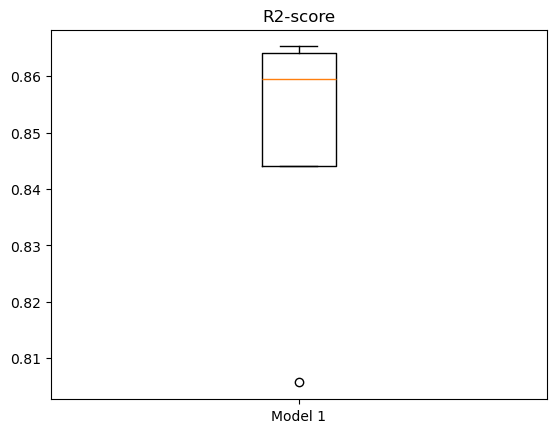

Mean of all temperatures: 34.42121913535249


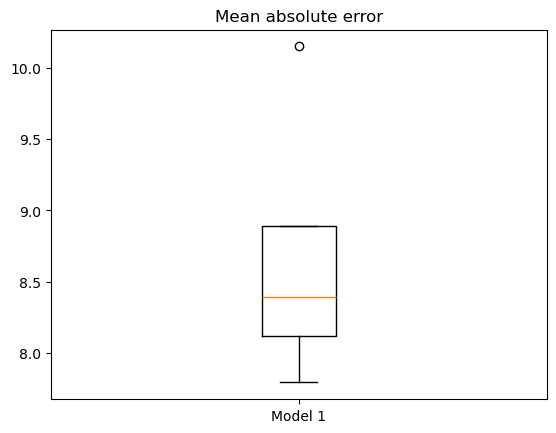

In [7]:
model1 = nn.Sequential(
    nn.Linear(X.shape[1], 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1))
model1.to(device=device)

r2Score1, MAE1 = train_model(model1, 5)
plt.boxplot(r2Score1, labels=["Model 1"])
plt.title("R2-score")
plt.show()

print(f"Mean of all temperatures: {np.mean(y)}")
plt.boxplot(MAE1, labels=["Model 1"])
plt.title("Mean absolute error")
plt.show()

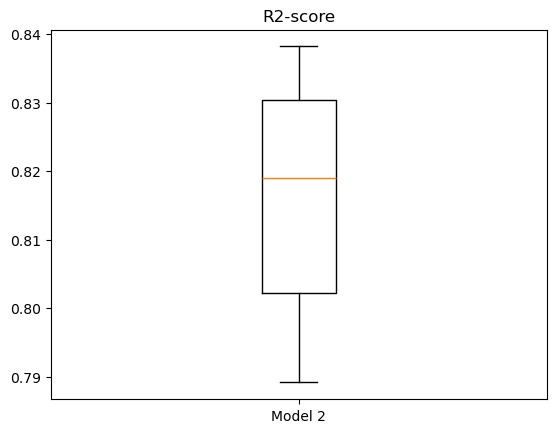

Mean of all temperatures:  34.42121913535249


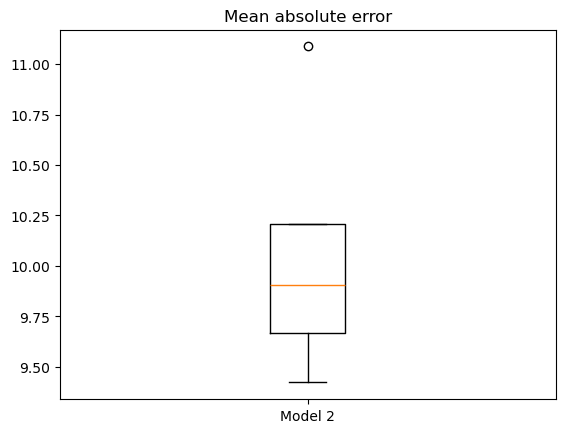

In [8]:
model2 = nn.Sequential(
    nn.Linear(X.shape[1], 100),
    nn.BatchNorm1d(100),
    nn.Sigmoid(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1))
model2.to(device=device)

r2Score2, MAE2 = train_model(model2, 5)
plt.boxplot(r2Score2, labels=["Model 2"])
plt.title("R2-score")
plt.show()

print("Mean of all temperatures: ", np.mean(y))
plt.boxplot(MAE2, labels=["Model 2"])
plt.title("Mean absolute error")
plt.show()

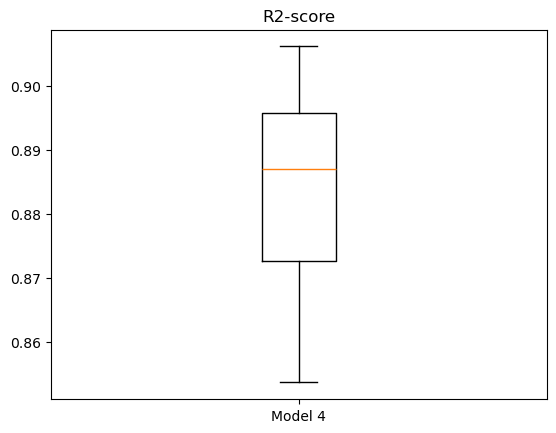

Mean of all temperatures:  34.42121913535249


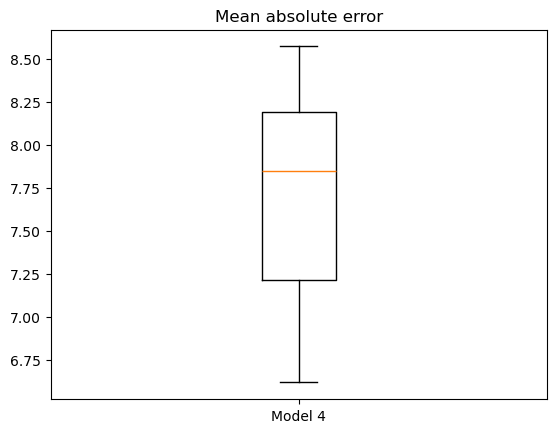

In [9]:
model4 = nn.Sequential(
    nn.Linear(X.shape[1], 50),
    nn.ReLU(),
    nn.Linear(50, 80),
    BatchPitNorm1d(num_features=80, num_pit_samples=500, take_num_samples_when_full=0,
                    normal_backtransform=True, trainable_bandwidths=False, bw_select = "RuleOfThumb", dev=device),
    nn.ReLU(),
    nn.Linear(80, 10),
    nn.ReLU(),
    nn.Linear(10, 1))
model4.to(device=device)

r2Score4, MAE4 = train_model(model4, 5)
plt.boxplot(r2Score4, labels=["Model 4"])
plt.title("R2-score")
plt.show()

print("Mean of all temperatures: ", np.mean(y))
plt.boxplot(MAE4, labels=["Model 4"])
plt.title("Mean absolute error")
plt.show()

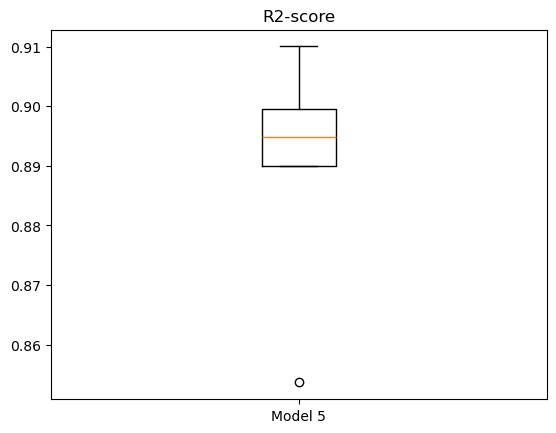

Mean of all temperatures:  34.42121913535249


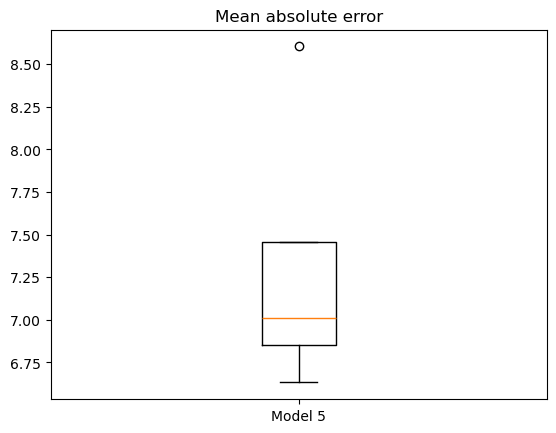

In [10]:
model5 = nn.Sequential(
    nn.Linear(X.shape[1], 50),
    BatchPitNorm1d(num_features=50, num_pit_samples=50, take_num_samples_when_full=0,
                    normal_backtransform=False, trainable_bandwidths=True, bw_select = "RuleOfThumb", dev=device),
    nn.ReLU(),
    nn.Linear(50, 80),
    nn.ReLU(),
    nn.BatchNorm1d(80),
    nn.Linear(80, 10),
    nn.ReLU(),
    nn.Linear(10, 1))
model5.to(device=device)

r2Score5, MAE5 = train_model(model5, 5)
plt.boxplot(r2Score5, labels=["Model 5"])
plt.title("R2-score")
plt.show()

print("Mean of all temperatures: ", np.mean(y))
plt.boxplot(MAE5, labels=["Model 5"])
plt.title("Mean absolute error")
plt.show()

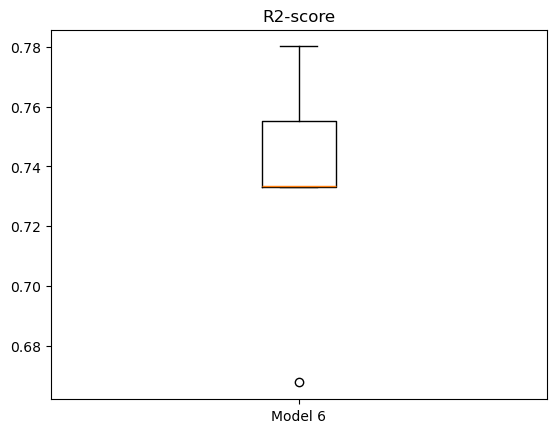

Mean of all temperatures:  34.42121913535249


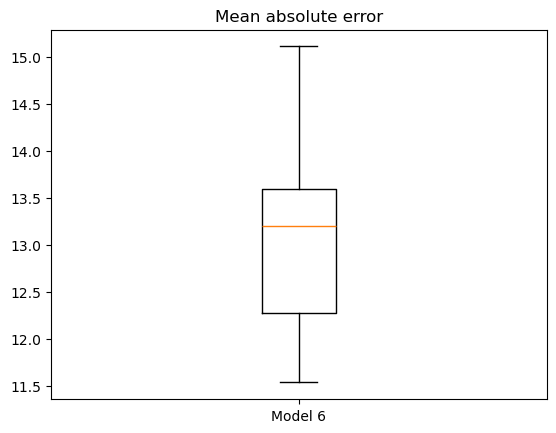

In [11]:
model6 = nn.Sequential(
    nn.Linear(X.shape[1], 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 50),
    nn.Dropout(p=0.3),
    nn.ReLU(),
    nn.Linear(50, 10),
    BatchPitNorm1d(num_features=10, num_pit_samples=50, take_num_samples_when_full=5,
                    normal_backtransform=False, trainable_bandwidths=True, bw_select = "RuleOfThumb", dev=device),
    nn.ReLU(),
    nn.Linear(10, 1))
model6.to(device=device)

r2Score6, MAE6 = train_model(model6, 5)
plt.boxplot(r2Score6, labels=["Model 6"])
plt.title("R2-score")
plt.show()

print("Mean of all temperatures: ", np.mean(y))
plt.boxplot(MAE6, labels=["Model 6"])
plt.title("Mean absolute error")
plt.show()

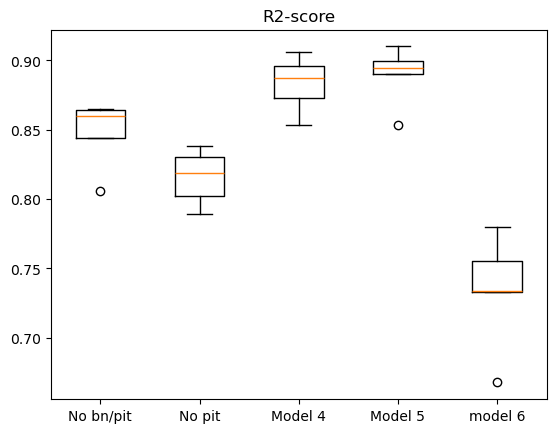

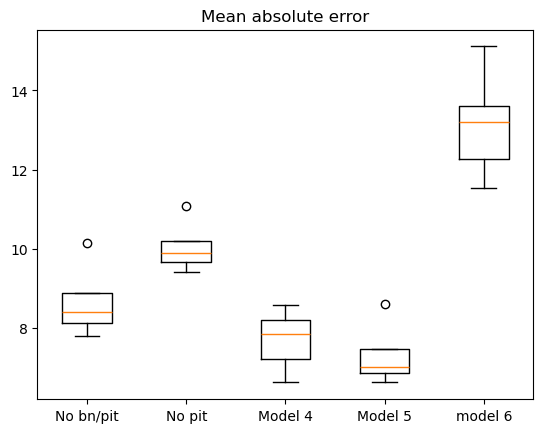

Mean of all temperatures:  34.42121913535249


In [12]:
plt.boxplot([r2Score1, r2Score2, r2Score4, r2Score5, r2Score6], labels=["No bn/pit", "No pit", "Model 4", "Model 5", "model 6"])
plt.title("R2-score")
plt.show()

plt.boxplot([MAE1, MAE2, MAE4, MAE5, MAE6], labels=["No bn/pit", "No pit", "Model 4", "Model 5", "model 6"])
plt.title("Mean absolute error")
plt.show()

print("Mean of all temperatures: ", np.mean(y))

These models seems to be okay good. The R2-score for most of the models is pretty high, but still not perfect. Almost the same for the mean absolute error, but the error seems to be a bit higher compared to the mean of the critical temperatures.